### Imports

In [52]:
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']


# uses custom metis style sheet for notebooks
from IPython.core.display import HTML
HTML("""<link rel="stylesheet" href="https://soph.info/metis/nb.css" type="text/css"/>""")

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns

# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
# gensim
import gensim

# keras
from keras.models import Sequential
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional)
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop


# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Cleaning df1

In [0]:
df1 = pd.read_csv('NewsArticles.csv',encoding='latin1')

In [0]:
df1 = df1[['article_id', 'publish_date', 'article_source_link', 'title',
       'subtitle', 'text']]

In [58]:
df1.head()

,article_id,publish_date,article_source_link,title,subtitle,text
0,1,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,"Betsy DeVos Confirmed as Education Secretary, ...",NaN,Michigan billionaire education activist Betsy ...
1,2,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,Melania Trump Says White House Could Mean Mill...,NaN,First lady Melania Trump has said little about...
2,3,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,"As Trump Fears Fraud, GOP Eliminates Election ...",NaN,A House committee voted on Tuesday to eliminat...
3,4,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,Appeals Court to Decide on Challenge to Trump'...,NaN,"This afternoon, three federal judges from the ..."
4,5,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At Least 4 Tornadoes Reported in Southeast Lou...,NaN,At least four tornadoes touched down in Louisi...


In [59]:
df1['article_source_link'][1].split('/')[2].split('.')[0]

'abcnews'

In [0]:
df1['pub'] = df1['article_source_link'].str.split('//').str[1]

In [0]:
df1['pub2'] = df1['pub'].str.split('.').str[0]

In [0]:
df1.drop(['pub'],axis=1,inplace=True)

In [0]:
df1.rename({'pub2':'publication','publish_date':'date','article_source_link':'url','text':'content'},axis=1,inplace=True)

In [0]:
df1.drop(['article_id'],axis=1,inplace=True)

In [0]:
df1['title1'] = df1[['title','subtitle']].astype(str).apply(lambda x:' '.join(x),axis=1)

In [0]:
df1.drop(['title','subtitle'],axis=1,inplace=True)

In [67]:
df1.head()

,date,url,content,publication,title1
0,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,Michigan billionaire education activist Betsy ...,abcnews,"Betsy DeVos Confirmed as Education Secretary, ..."
1,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,First lady Melania Trump has said little about...,abcnews,Melania Trump Says White House Could Mean Mill...
2,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,A House committee voted on Tuesday to eliminat...,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ..."
3,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,"This afternoon, three federal judges from the ...",abcnews,Appeals Court to Decide on Challenge to Trump'...
4,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At least four tornadoes touched down in Louisi...,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...


### Cleaning the rest if dfs

In [0]:
df2 = pd.read_csv('articles1.csv')

In [0]:
df3 = pd.read_csv('articles2.csv')

In [0]:
df4 = pd.read_csv('articles3.csv')

In [0]:
df_pre = pd.concat([df2,df3,df4],axis=0)

In [72]:
df_pre.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [0]:
df_pre.drop(['Unnamed: 0', 'id','author','year', 'month'],axis=1,inplace=True)

In [74]:
df_pre.head()

,title,publication,date,url,content
0,House Republicans Fret About Winning Their Hea...,New York Times,2016-12-31,NaN,WASHINGTON — Congressional Republicans have...
1,Rift Between Officers and Residents as Killing...,New York Times,2017-06-19,NaN,"After the bullet shells get counted, the blood..."
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,2017-01-06,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,2017-04-10,NaN,"Death may be the great equalizer, but it isn’t..."
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,2017-01-02,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [75]:
df1.head()

,date,url,content,publication,title1
0,2017/2/7,http://abcnews.go.com/Politics/pence-break-tie...,Michigan billionaire education activist Betsy ...,abcnews,"Betsy DeVos Confirmed as Education Secretary, ..."
1,2017/2/7,http://abcnews.go.com/Politics/wireStory/melan...,First lady Melania Trump has said little about...,abcnews,Melania Trump Says White House Could Mean Mill...
2,2017/2/7,http://abcnews.go.com/Politics/wireStory/trump...,A House committee voted on Tuesday to eliminat...,abcnews,"As Trump Fears Fraud, GOP Eliminates Election ..."
3,2017/2/7,http://abcnews.go.com/Politics/appeals-court-d...,"This afternoon, three federal judges from the ...",abcnews,Appeals Court to Decide on Challenge to Trump'...
4,2017/2/7,http://abcnews.go.com/US/23-states-winter-weat...,At least four tornadoes touched down in Louisi...,abcnews,At Least 4 Tornadoes Reported in Southeast Lou...


### Full df

In [76]:
df = pd.concat([df1,df_pre],axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146394 entries, 0 to 42570
Data columns (total 6 columns):
content        146361 non-null object
date           143753 non-null object
publication    146394 non-null object
title          142568 non-null object
title1         3824 non-null object
url            89383 non-null object
dtypes: object(6)
memory usage: 7.8+ MB


In [0]:
df['title+content'] = df[['title','content']].astype(str).apply(lambda x:' '.join(x),axis=1)

In [79]:
df['publication'].value_counts()

Breitbart              23781
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11114
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7179
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
www                     2505
tass                     485
abcnews                  474
europe                   360
Name: publication, dtype: int64

In [0]:
df['publication'] = df['publication'].replace({'www':'CNN'})

In [0]:
df[['content','publication','title+content']] = df[['content','publication','title+content']].astype('str')

In [0]:
df['content'] = df['content'].astype('str')

In [0]:
df['title'] = df['title'].astype('str')

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146394 entries, 0 to 42570
Data columns (total 7 columns):
content          146394 non-null object
date             143753 non-null object
publication      146394 non-null object
title            146394 non-null object
title1           3824 non-null object
url              89383 non-null object
title+content    146394 non-null object
dtypes: object(7)
memory usage: 8.9+ MB


In [0]:
df['url'] = df['url'].fillna('No url')

### Processing text data 

In [0]:
import re 
import string 

In [0]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [0]:
df['content'] = df['content'].map(alphanumeric).map(punc_lower)

In [0]:
df['title'] = df['title'].map(alphanumeric).map(punc_lower)

In [0]:
df['title+content'] = df['title+content'].map(alphanumeric).map(punc_lower)

### LSTM Modeling 

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping


In [0]:
# The maximum number of words to be used. (most frequent)
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
MAX_NB_WORDS = 30000


In [0]:
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, filters="""!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',""")
tokenizer.fit_on_texts(df['title+content'].values)
word_index = tokenizer.word_index

In [0]:
# Convert tokenized sentences to sequence format
X = tokenizer.texts_to_sequences(df['title+content'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
Y = pd.get_dummies(df['publication']).values

In [0]:
Yx = pd.get_dummies(df['publication'])

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(117115, 250) (117115, 18)
(29279, 250) (29279, 18)


In [102]:
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=40, embeddings_initializer='glorot_uniform', input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(18, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 40)           1200000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 40)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_3 (Dense)              (None, 18)                1818      
Total params: 1,258,218
Trainable params: 1,258,218
Non-trainable params: 0
_________________________________________________________________


In [103]:
epochs = 10
batch_size = 64


model.fit(X_train, Y_train, batch_size=256, epochs=epochs, 
              validation_data=(X_test, Y_test))


W0829 22:55:42.864121 140301074454400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 117115 samples, validate on 29279 samples
Epoch 1/10
117115/117115 [==============================] - 216s 2ms/step - loss: 2.0767 - acc: 0.3352 - val_loss: 1.7167 - val_acc: 0.4494
Epoch 2/10
117115/117115 [==============================] - 211s 2ms/step - loss: 1.6127 - acc: 0.4874 - val_loss: 1.5879 - val_acc: 0.4909
Epoch 3/10
117115/117115 [==============================] - 216s 2ms/step - loss: 1.4200 - acc: 0.5523 - val_loss: 1.3409 - val_acc: 0.5776
Epoch 4/10
117115/117115 [==============================] - 215s 2ms/step - loss: 1.2273 - acc: 0.6141 - val_loss: 1.1951 - val_acc: 0.6231
Epoch 5/10
117115/117115 [==============================] - 208s 2ms/step - loss: 1.1124 - acc: 0.6506 - val_loss: 1.1468 - val_acc: 0.6445
Epoch 6/10
117115/117115 [==============================] - 208s 2ms/step - loss: 1.0048 - acc: 0.6826 - val_loss: 1.1107 - val_acc: 0.6527
Epoch 7/10
117115/117115 [==============================] - 207s 2ms/step - loss: 0.9431 - acc: 0.7024 - val_

In [0]:
hidden_features = model.predict(X_test)

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [106]:
pca = PCA(n_components=16)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 0.9992791414260864
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 0.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000004
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.818707
[t-SNE] KL divergence after 1000 iterations: 0.635639


In [107]:
np_utils.to_categorical(Y_test[1], num_classes=16)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

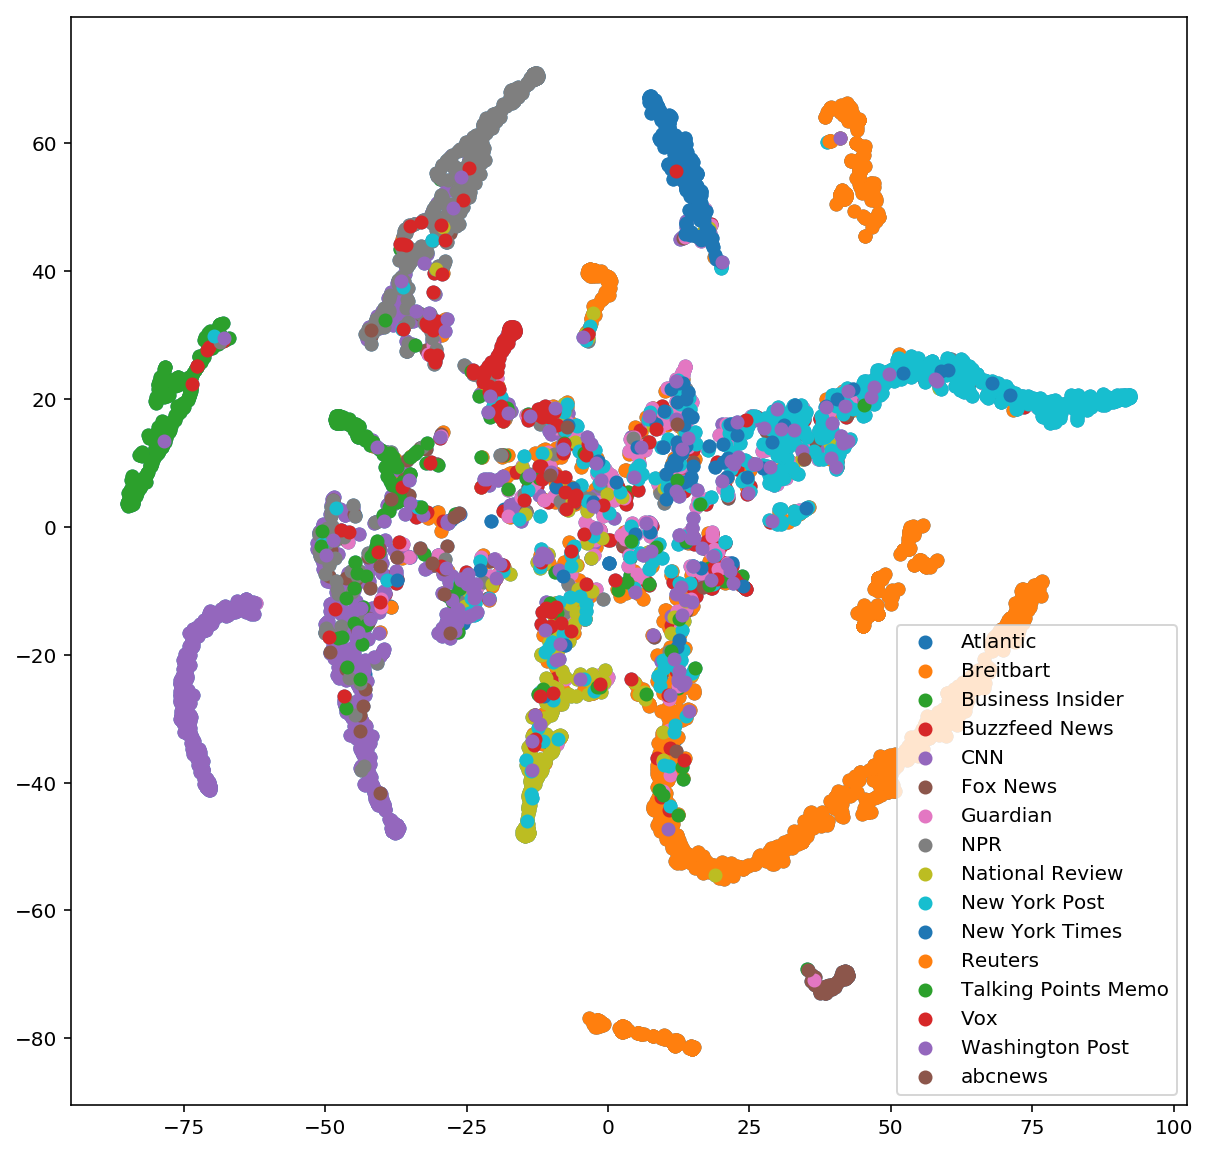

In [111]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(Y_test[:5000])
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(16):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend(Yx.columns)
plt.show()